# Run hacked AlphaFold2 on the designed binders

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_crispies
running on node: dig30


### Set working directory to the root of the crispy_shifty repo
Note: We want to use perlmutter

In [ ]:
os.chdir("/global/cfs/cdirs/m4129/projects/crispy_shifty")

### Fix the paths
Necessary because we are on perlmutter

In [ ]:
from crispy_shifty.utils.io import fix_path_prefixes

pairs = os.path.join(
    os.getcwd(), "projects/crispy_crispies/00_mpnn_binders/mpnn_binders.pair"
)
new_pairs = fix_path_prefixes(
    find="/mnt",
    replace="/global/cfs/cdirs/m4129",
    file=pairs,
    overwrite=True,
)

### Run AF2 on the designed bound states

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "01_fold_binders"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_crispies/00_mpnn_binders/mpnn_binders.pair",
)
output_path = os.path.join(f"/pscratch/sd/p/pleung/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {"models": "1"}

gen_array_tasks(
    distribute_func="projects.crispy_crispies.deployables.fold_binder",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="24:00",
)

In [ ]:
!sbatch -a 1-67 /pscratch/sd/p/pleung/01_fold_binders/run.sh

### Set working directory to the root of the crispy_shifty repo
Note: We rsync the perlmutter results, now back on the digs

In [2]:
os.chdir("/projects/crispy_shifty")

### Collect scorefiles of the folded bound states and concatenate

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "01_fold_binders"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [7]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

In [8]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

1036
['bb_clash', 'binder_blocked_sap', 'buns_heavy_ball_1.1D', 'chA_length', 'chA_seq', 'closure_type', 'contact_molec_sq5_ap_target', 'contact_molec_sq5_apap_target', 'contact_molecular_surface', 'contact_molecular_surface_ap_target', 'contact_molecular_surface_apap_target', 'contact_patch', 'ddg', 'ddg_hydrophobic', 'designed_by', 'disulfide_at', 'docked_helix', 'elapsed_time', 'fa_atr_pocket', 'hydrophobic_residue_contacts', 'interface_buried_sasa', 'interface_hydrophobic_count', 'interface_hydrophobics', 'interface_polar_count', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_resis', 'pTMscore', 'parent', 'parent_length', 'pivot_helix', 'pre_break_helix', 'prefix', 'recycles', 'rmsd', 'rmsd_to_reference', 'sap_score', 'sap_score_target', 'sbuns5.0_heavy_ball_1.1D', 'score_per_res', 'seed', 'sh

In [9]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot before and after interface design AF2 metrics

4it [00:00,  9.08it/s]


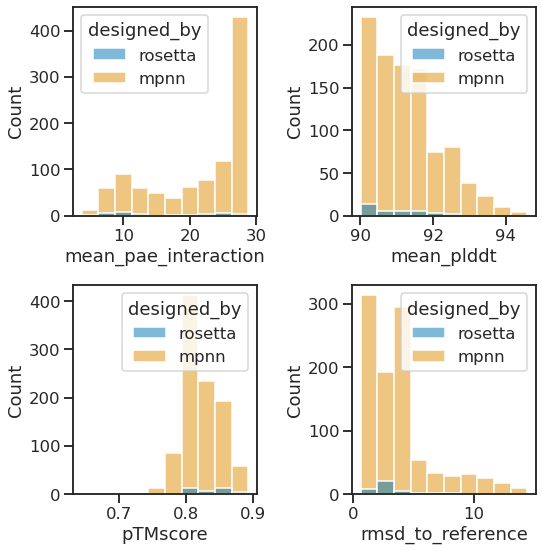

In [10]:
cols = [
    "mean_pae_interaction",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

0it [00:00, ?it/s]


ValueError: Could not interpret value `best_average_plddts` for parameter `x`

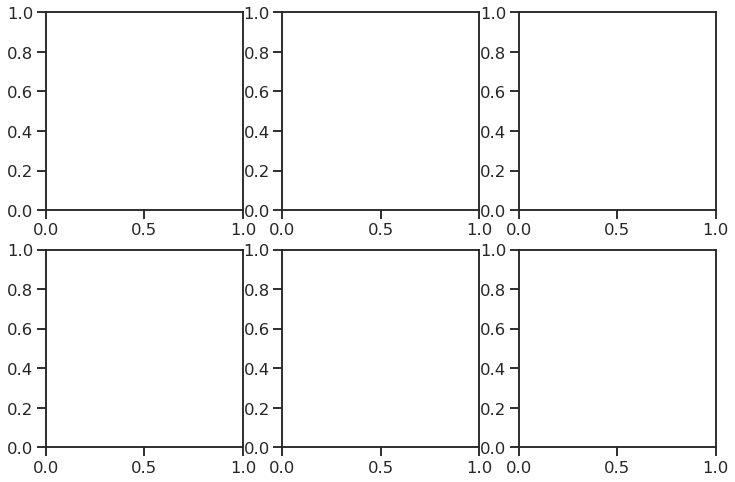

In [11]:
mpnn["mpnn_temperature"] = mpnn["mpnn_temperature"].astype(str)

cols = [
    "best_average_plddts",
    "best_ptm",
    "best_rmsd_to_input",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_temperature",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_temp.png"))

In [ ]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_temperature",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_temp_paired.png"))

In [ ]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_design_area",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area.png"))

In [ ]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_design_area",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

In [ ]:
# sample_df["best_model"] = sample_df["best_model"].astype(str)
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="best_model",
# )

In [ ]:
# sample_df["best_model"] = sample_df["best_model"].astype(str)
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="topo",
# )

### Plot interface metrics

In [ ]:
cols = [
    "cms_AnAcB",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "sc_AnAcB",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores.png"))

In [ ]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores_paired.png"))

### Filter the whole df

In [12]:
query = "mean_pae_interaction <10 and mean_plddt > 92 and rmsd_to_reference < 1.75"

filtered = scores_df.query(query)
len(filtered)

388

In [13]:
filtered.groupby("target_name").count()

,bb_clash,binder_blocked_sap,buns_heavy_ball_1.1D,chA_length,chA_seq,closure_type,contact_molec_sq5_ap_target,contact_molec_sq5_apap_target,contact_molecular_surface,contact_molecular_surface_ap_target,...,target_seq,threaded_seq,tol,total_length,total_score,type,vbuns5.0_heavy_ball_1.1D,wnm_all,wnm_hlx,cart_bonded
target_name,,,,,,,,,,,,,,,,,,,,,
gip,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
glp,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,0
glucagon,41,41,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,41,41,41,0
neuropeptideY,225,225,225,225,225,225,225,225,225,225,...,225,225,225,225,225,225,225,225,225,4
pth,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,18


### Make seperate dfs of binders for the GIP/GLP/Glucagon family and for NPY

In [14]:
gip = filtered.query("target_name == 'gip'")
glp = filtered.query("target_name == 'glp'")
gluc = filtered.query("target_name == 'glucagon'")
npy = filtered.query("target_name == 'neuropeptideY'")

### Save a list of outputs
Sort by length  

In [15]:
simulation_name = "01_fold_binders"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
filtered = filtered.sort_values("total_length")
with open(os.path.join(output_path, "folded_binders.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)
with open(os.path.join(output_path, "gip.list"), "w") as f:
    for path in tqdm(gip.index):
        print(path, file=f)
with open(os.path.join(output_path, "glp.list"), "w") as f:
    for path in tqdm(glp.index):
        print(path, file=f)
with open(os.path.join(output_path, "gluc.list"), "w") as f:
    for path in tqdm(gluc.index):
        print(path, file=f)
with open(os.path.join(output_path, "npy.list"), "w") as f:
    for path in tqdm(npy.index):
        print(path, file=f)

  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

### Fix the paths
Necessary because we transferred from perlmutter

In [16]:
from crispy_shifty.utils.io import fix_path_prefixes

for l in "gip", "glp", "gluc", "npy":

    _ = fix_path_prefixes(
        find="/pscratch/sd/p/pleung",
        replace="/mnt/projects/crispy_shifty/projects/crispy_crispies",
        file=os.path.join(
            os.getcwd(), f"projects/crispy_crispies/01_fold_binders/{l}.list"
        ),
        overwrite=True,
    )

### Save a list of chunked outputs
50 per chunk

In [17]:
from more_itertools import ichunked

with open(os.path.join(output_path, "folded_binders.pair"), "w") as f:
    for paths in ichunked(tqdm(filtered.index), 50):
        line = "____".join(paths)
        print(line, file=f)

  0%|          | 0/388 [00:00<?, ?it/s]

### Prototyping blocks